In [97]:
%pylab inline
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import zipfile
import nltk,re, string
import matplotlib.pyplot as plt
from sklearn import metrics, model_selection, preprocessing, pipeline, feature_extraction, decomposition, linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor

Populating the interactive namespace from numpy and matplotlib


/Users/sasali/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Load data

In [98]:
trainv = pd.read_csv('training_variants')
testv = pd.read_csv('test_variants')
trainx = pd.read_csv('training_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
testx = pd.read_csv('test_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

In [99]:
print("Train Variant".ljust(15), trainv.shape)
print("Train Text".ljust(15), trainx.shape)
print("Test Variant".ljust(15), testv.shape)
print("Test Text".ljust(15), testx.shape)

Train Variant   (3321, 4)
Train Text      (3321, 2)
Test Variant    (5668, 3)
Test Text       (5668, 2)


We have 3321 obs. in training set and 5668 obs. in test set.

In [81]:
trainv.head(20)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


In [82]:
trainx.head(2)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...


In [83]:
train = pd.merge(trainv, trainx, how='left', on='ID')
y = train['Class'].values
train = train.drop('Class', axis=1)
test = pd.merge(testv, testx, how='left', on='ID')
# merge train and test to explore the genes and variations
df = pd.concat((train, test), axis=0, ignore_index=True)

# Data Exploration for Variants

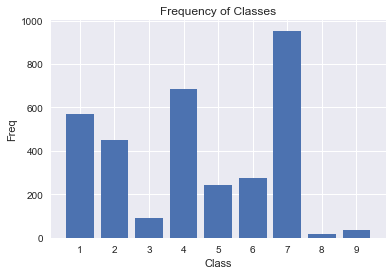

In [84]:
from collections import Counter
ClassDict = Counter(trainv['Class'])
plt.bar(range(len(ClassDict)), ClassDict.values(), align='center')
plt.xticks(range(len(ClassDict)), ClassDict.keys())
plt.title("Frequency of Classes")
plt.ylabel('Freq')
plt.xlabel('Class')
plt.show()

Imbalanced data distribution.  Most of the mutations belong to Class 1,2,4,7. This may cause a bias in the training process and it may require special attention to improve the ML performance. 

Let us check the distribution of relevant genes.

In [85]:
UniqGeneTr = train['Gene'].unique()
UniqGeneTe = test['Gene'].unique()

print('Num of unique genes in training set: ', len(UniqGeneTr))
print('Num of unique genes in testing set: ', len(UniqGeneTe))

CommonGene = np.intersect1d(UniqGeneTr, UniqGeneTe, assume_unique=True)
len(SharedGene)

Num of unique genes in training set:  264
Num of unique genes in testing set:  1397


154

Only 154 genes exist in both train and test sets

In [86]:
UniqVarTr = train['Variation'].unique()
UniqVarTe = test['Variation'].unique()

print('Num of unique Variations in training set: ', len(UniqVarTr))
print('Num of unique Variations in testing set: ', len(UniqVarTe))

CommonVar = np.intersect1d(UniqVarTr, UniqVarTe, assume_unique=True)
len(CommonVar)


Num of unique Variations in training set:  2996
Num of unique Variations in testing set:  5628


15

Only 15 variations exist in both sets. Variation itself may not be a very useful feature for prediction

In [87]:
# How many uniques genes are involved in each mutation class?
GeneDict = {}
VarDict = {}
classList = array(range(9))+1
for i in classList:
    GeneDict[i] = trainv[trainv.Class==i].Gene.nunique()
    VarDict[i] = trainv[trainv.Class==i].Variation.nunique()
print('Gene Dictionary:', GeneDict)
print('Variation Dictionary:', VarDict)

Gene Dictionary: {1: 142, 2: 96, 3: 26, 4: 92, 5: 48, 6: 56, 7: 108, 8: 12, 9: 10}
Variation Dictionary: {1: 423, 2: 399, 3: 89, 4: 669, 5: 242, 6: 265, 7: 889, 8: 19, 9: 37}


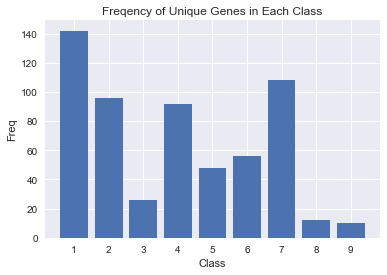

In [88]:
plt.bar(range(len(GeneDict)), GeneDict.values(), align='center')
plt.xticks(range(len(GeneDict)), GeneDict.keys())
plt.title('Freqency of Unique Genes in Each Class')
plt.ylabel('Freq')
plt.xlabel('Class')
plt.show()

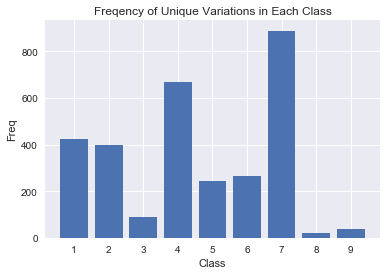

In [89]:
plt.bar(range(len(VarDict)), VarDict.values(), align='center')
plt.xticks(range(len(VarDict)), VarDict.keys())
plt.title('Freqency of Unique Variations in Each Class')
plt.ylabel('Freq')
plt.xlabel('Class')
plt.show()

# Cleaning text data

In [90]:
from nltk.corpus import stopwords
stop_words =  set(stopwords.words('english'))
punct = set(string.punctuation)
def tokenizer(text):
    text = re.sub('[\(\)\{\}<>]', '', text)
    temp = [nltk.stem.snowball.SnowballStemmer("english").stem(word) for word in text.split()]
    # removing stop words, punctuation and digits
    words = [w for w in temp if w not in stop_words and sum(char in punct for char in w)==0 and not str.isdigit(w)]
    return words

In [91]:
df.columns

Index(['ID', 'Gene', 'Variation', 'Text'], dtype='object')

In [92]:
# Label encode the categorical columns
for c in df.columns:
    if df[c].dtype == 'object':
        if c in ['Gene','Variation']:
            lbl = preprocessing.LabelEncoder()
            df[c+'_lbl_enc'] = lbl.fit_transform(df[c].values)  
            df[c+'_len'] = df[c].map(lambda x: len(str(x)))
            df[c+'_words'] = df[c].map(lambda x: len(str(x).split(' ')))
        elif c != 'Text':
            lbl = preprocessing.LabelEncoder()
            df[c] = lbl.fit_transform(df[c].values)
        if c=='Text': 
            df[c+'_len'] = df[c].map(lambda x: len(str(x)))
            df[c+'_words'] = df[c].map(lambda x: len(str(x).split(' ')))

In [93]:
train_new = df.iloc[:len(train)]
test_new = df.iloc[len(train):]

In [94]:
class cust_regression_vals(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x = x.drop(['Gene', 'Variation','ID','Text'],axis=1).values
        return x

class cust_txt_col(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        return x[self.key].apply(str)
    
class ModelTransformer(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):

    def __init__(self, model):
        self.model = model

    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self

    def transform(self, X, **transform_params):
        return DataFrame(self.model.predict(X))

In [105]:
print('Pipeline...')
fp = pipeline.Pipeline([
    ('features', pipeline.FeatureUnion(
        n_jobs = -1,
        transformer_list = [
            ('standard', cust_regression_vals()),
            ('pi1', pipeline.Pipeline([('Gene', cust_txt_col('Gene')), 
                                       ('count_Gene', feature_extraction.text.CountVectorizer(analyzer=u'char', ngram_range=(1, 8))), 
                                       ('tsvd1', decomposition.TruncatedSVD(n_components=20, n_iter=25, random_state=3))])),
            ('pi2', pipeline.Pipeline([('Variation', cust_txt_col('Variation')), 
                                       ('count_Variation', feature_extraction.text.CountVectorizer(analyzer=u'char', ngram_range=(1, 8))), 
                                       ('tsvd2', decomposition.TruncatedSVD(n_components=20, n_iter=25, random_state=3))])),
            ('pi3', pipeline.Pipeline([('Text', cust_txt_col('Text')), 
                                       ('tfidf_Text', feature_extraction.text.TfidfVectorizer(ngram_range=(1, 2))), 
                                       ('tsvd3', decomposition.TruncatedSVD(n_components=100, n_iter=25, random_state=3))]))
        ])),
    ('estimators', pipeline.FeatureUnion([
        #('gbr', ModelTransformer(GradientBoostingRegressor())),
        #('dtr', ModelTransformer(DecisionTreeRegressor())),
        ('lr', ModelTransformer(LogisticRegression()))
        #('par', ModelTransformer(PassiveAggressiveRegressor())),
        #('en', ModelTransformer(ElasticNet()))]
    ]))])

Pipeline...


In [ ]:
model = fp.fit_transform(train_new)

In [ ]:
x1, x2, y1, y2 = model_selection.train_test_split(train, y, test_size=0.15, random_state=3)

In [ ]:
y = y - 1 #fix for zero bound array

denom = 0
fold = 1 #Change to 5, 1 for Kaggle Limits
for i in range(fold):
    params = {
        'eta': 0.03333,
        'max_depth': 4,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 9,
        'seed': i,
        'silent': True
    }
    x1, x2, y1, y2 = model_selection.train_test_split(train, y, test_size=0.18, random_state=i)
    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
    model = xgb.train(params, xgb.DMatrix(x1, y1), 1000,  watchlist, verbose_eval=50, early_stopping_rounds=100)
    score1 = metrics.log_loss(y2, model.predict(xgb.DMatrix(x2), ntree_limit=model.best_ntree_limit), labels = list(range(9)))
    print(score1)
    #if score < 0.9:
    if denom != 0:
        pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
        preds += pred
    else:
        pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
        preds = pred.copy()
    denom += 1
    submission = pd.DataFrame(pred, columns=['class'+str(c+1) for c in range(9)])
    submission['ID'] = pid
    submission.to_csv('submission_xgb_fold_'  + str(i) + '.csv', index=False)
preds /= denom
submission = pd.DataFrame(preds, columns=['class'+str(c+1) for c in range(9)])
submission['ID'] = pid
submission.to_csv('submission_xgb.csv', index=False)